## Initial Explorative Data Analysis of Helium Blockchain Data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import numpy as np
import plotly.express as px

In [40]:
df = pd.read_csv('../data/raw/helium-api-data.csv')
# add positive rssi column
df['rssi_positive'] = df['rssi'] * -1

df.shape

(60, 12)

In [41]:
df.head()

,key,ylat,ylon,xlat,xlon,rssi,snr,freq,datarate,valid,distance,rssi_positive
0,0,41.748064,-73.659576,41.734572,-73.692091,-80,11.8,904.099976,SF9BW125,True,3086.783267,80
1,0,41.748064,-73.659576,41.765272,-73.633632,-83,11.5,904.099976,SF9BW125,True,2879.681279,83
2,0,41.748064,-73.659576,41.728785,-73.705810,-91,11.0,904.099976,SF9BW125,True,4394.474207,91
3,1,38.229129,21.762428,38.220871,21.794480,-106,1.2,867.900024,SF12BW125,True,2946.592328,106
4,1,38.229129,21.762428,38.194222,21.723213,-109,-0.2,867.900024,SF12BW125,True,5177.357662,109


### Geolocations
Visualization of different challenges on a map.

In [18]:
color_scale = [(0, 'orange'), (1,'red')]

fig = px.scatter_mapbox(df,
                        lat="xlat",
                        lon="xlon",
                        hover_name="key",
                        hover_data=["key", "rssi"],
                        color="key",
                        #color_continuous_scale=color_scale,
                        size="rssi_positive",
                        zoom=2,
                        height=600,
                        width=1000)

fig.add_scattermapbox(lat=df.ylat, lon=df.ylon)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Signal & Distance
Assumption: We loose signal strength with increasing distance.

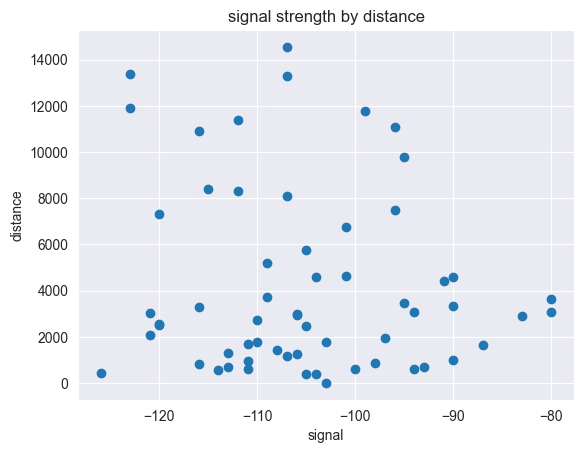

In [19]:
plt.scatter('rssi', 'distance', data=df)
plt.title('signal strength by distance')
plt.xlabel('signal')
plt.ylabel('distance')
plt.show()

Next we look at *signal-to-noise ratio (SNR)*.
Signal-to-noise ratio is a measure used in science and engineering that compares the level of a desired signal to the level of background noise.
SNR is defined as the ratio of signal power to the noise power, often expressed in decibels.
A ratio higher than 1:1 indicates more signal than noise.

We want to see if signal-to-noise ratio changes by distance or by signal strength.

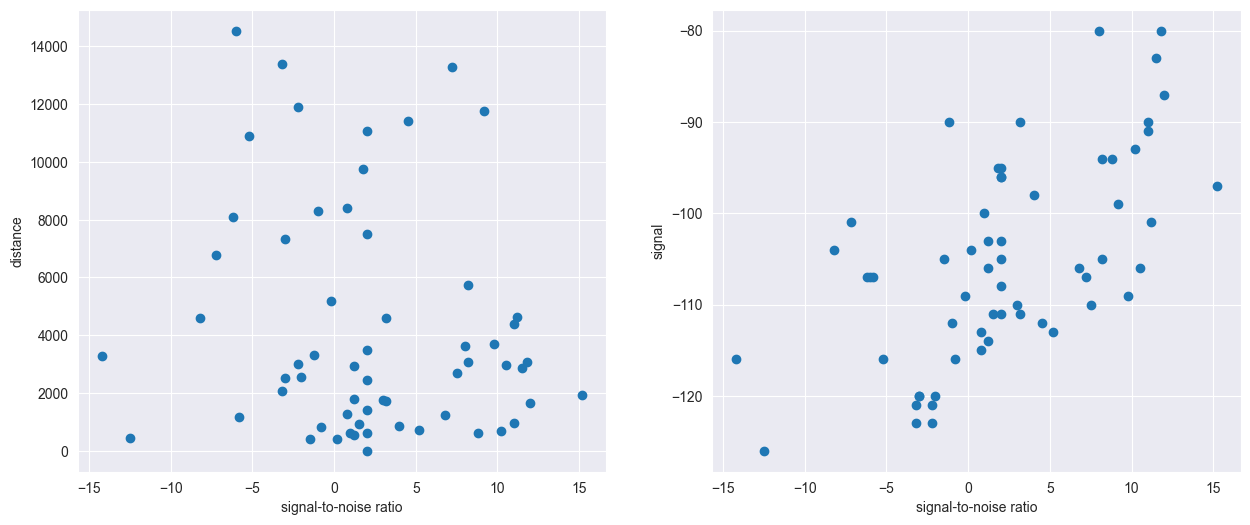

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter('snr', 'distance', data=df)
ax1.set_xlabel('signal-to-noise ratio')
ax1.set_ylabel('distance')

ax2.scatter('snr', 'rssi', data=df)
ax2.set_xlabel('signal-to-noise ratio')
ax2.set_ylabel('signal')

plt.show()

Helium's LoRaWAN Network is built upon 8-channel gateways. The datarate depends on the country or region, a hotspot is located.
[Reference](https://docs.helium.com/lorawan-on-helium/frequency-plans/)

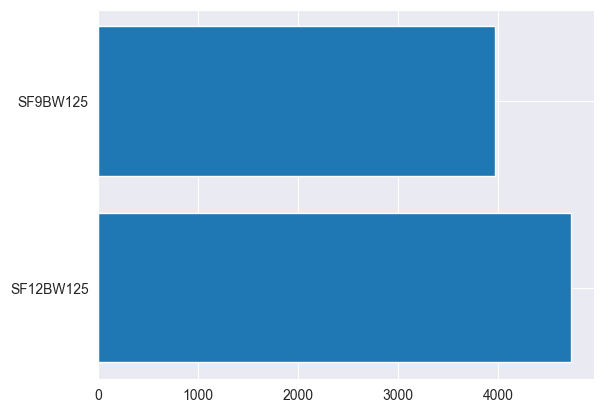

In [7]:
plt.barh('datarate', 'distance', data=df.groupby('datarate')['distance'].mean().reset_index())
plt.show()

### Simple Model
Before we train a simple model on the available data, we estimate a baseline RMSE.
Therefore, we assume, that there is no model at all and we estimate the location to be at the position of the witness with the strongest signal.
Then we look at the error.
Every model *must* perform better than this baseline estimation.

In [8]:
# filter best signal
df_best_signal = df[df['rssi']==df.groupby('key')['rssi'].transform('max')]

mse = np.square(df_best_signal['distance']).mean()
rsme = math.sqrt(mse)
print(rsme)

4524.994304467817


Now we train a very Simple Linear Regression model based on the features available.

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [39]:
df['datarate_enc'] = [0 if x == 'SF9BW125' else 1 for x in df['datarate']]

# features = ['rssi', 'snr', 'datarate_enc']
features = ['rssi', 'snr']
X = df[features]
y = df['distance'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

model = LinearRegression().fit(X=X_train, y=y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rsme = math.sqrt(mse)
print(rsme)

2128.501691150313
